# Load py_ballisticcalc and set units

In [1]:
import logging
from matplotlib import pyplot as plt
from py_ballisticcalc import (DragModel, TableG1, Ammo, Weapon, Shot, Atmo, Vacuum, Wind,
                              Calculator, HitResult, TrajFlag, logger, BaseEngineConfigDict)
from py_ballisticcalc.unit import *
PreferredUnits.distance = Unit.Meter
PreferredUnits.velocity = Unit.MPS
PreferredUnits.drop = Unit.Meter
logger.setLevel(logging.WARNING)

# Ex.1: Shot hits minimum altitude before end of range

Using a projectile with a very low BC (meaning not very aerodynamic).  We simulate a shot starting at altitude of 1000m above ground level and ask for trajectory going 1000m downrange.  Simulation reports it hitting ground level before it can travel 1000m horizontally.

Max range not reached: (Minimum altitude reached), last distance: 2150.64ft


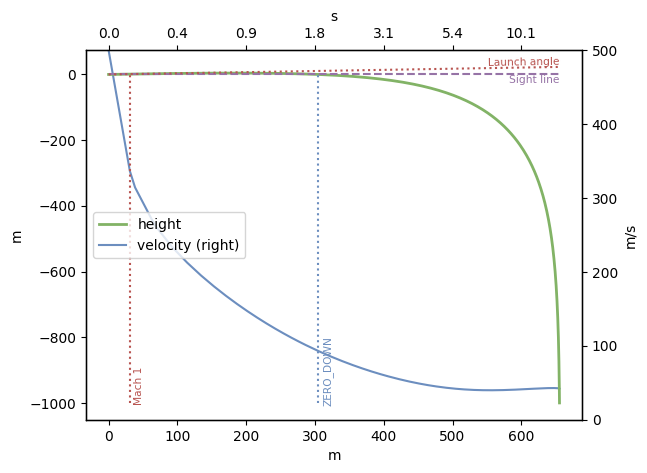

In [2]:
drag_model = DragModel(bc=0.03, drag_table=TableG1)  # Projectile has G1 BC of 0.03
zero = Shot(ammo=Ammo(drag_model, Velocity.MPS(500)),  # Muzzle velocity is 500m/s
            atmo=Atmo(altitude=Distance.Meter(1000)),  # Shot is fired at an altitude of 1000m ASL
            relative_angle=Angular.Degree(2.0)  # Point barrel 2° above horizon
)
calc = Calculator(config={
        "cMinimumVelocity": 0,  # Run simulation as long as velocity is non-zero
        "cMinimumAltitude": 0,  # Stop simulation at sea level
})
# Compute trajectory out to horizontal range of 1000m
hit_result = calc.fire(zero, Distance.Meter(1000), time_step=0.1, flags=TrajFlag.ALL, raise_range_error=False)
if hit_result.error:
    print(hit_result.error)
hit_result.plot()
plt.show()

## Inspect data
We can see that shot begins pointing 2° above horizon, but after 28 seconds and 655m travel downrange it has almost no forward velocity.  Instead it has reached its terminal velocity of 42m/s and is falling almost vertically.

In [3]:
df = hit_result.dataframe(True).drop(['slant_height', 'drop_adj', 'windage', 'windage_adj', 'slant_distance', 'energy', 'ogw', 'flag'], axis=1).set_index('distance')
#df.to_clipboard()
display(df.head(3))
display(df.tail(3))

,time,velocity,mach,height,angle,density_ratio,drag
distance,,,,,,,
0.0 m,0.000 s,500 m/s,1.49 mach,-0.0 m,2.0000 °,9.07483e-01,4.577e-03
30.9 m,0.077 s,336 m/s,1.00 mach,1.1 m,1.8920 °,9.07483e-01,3.340e-03
38.5 m,0.100 s,314 m/s,0.93 mach,1.3 m,1.8516 °,9.07483e-01,2.680e-03


,time,velocity,mach,height,angle,density_ratio,drag
distance,,,,,,,
655.5 m,28.400 s,42 m/s,0.12 mach,-995.2 m,-89.7414 °,9.99564e-01,1.705e-03
655.5 m,28.500 s,42 m/s,0.12 mach,-999.4 m,-89.7473 °,9.99968e-01,1.705e-03
655.5 m,28.515 s,42 m/s,0.12 mach,-1000.1 m,-89.7482 °,1.00003e+00,1.705e-03


# Ex.2: Dropped Projectile
Same projectile, dropped from an altitude of 1000m

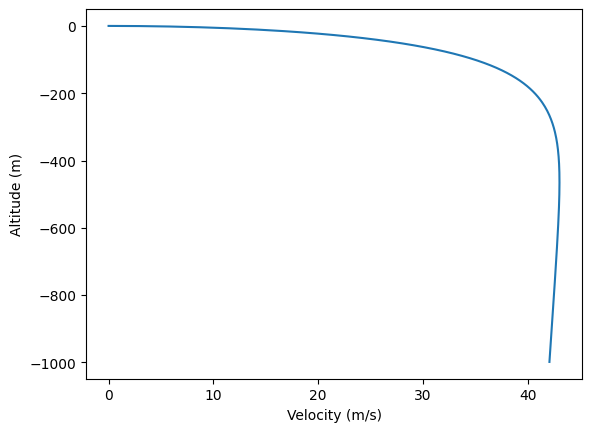

In [4]:
zero = Shot(ammo=Ammo(drag_model, Velocity.MPS(0)),  # Projectile starts with no velocity
            atmo=Atmo(altitude=Distance.Meter(1000)),  # Projectile dropped from an altitude of 1000m ASL
)
hit_result = calc.fire(zero, Distance.Meter(1000), time_step=0.1, raise_range_error=False)
drop_df = hit_result.dataframe()
ax = drop_df.plot(x='velocity', y='height', xlabel='Velocity (m/s)', ylabel='Altitude (m)', legend=False)

## Inspect data
Maximum velocity of 43m/s is achieved after falling 463.9m.  Thereafter the terminal velocity decreases to 42m/s as the projectile encounters increasingly dense atmosphere.

In [5]:
df = hit_result.dataframe(True).drop(['distance', 'slant_height', 'drop_adj', 'windage', 'windage_adj', 'slant_distance', 'energy', 'ogw', 'flag'], axis=1)
max_velocity_row = drop_df[drop_df.velocity == drop_df.velocity.max()].index[0]
display(df[df.index == max_velocity_row])
df.tail(1)

,time,velocity,mach,height,angle,density_ratio,drag
138,13.800 s,43 m/s,0.13 mach,-465.9 m,-90.0000 °,9.49744e-01,1.700e-03


,time,velocity,mach,height,angle,density_ratio,drag
263,26.300 s,42 m/s,0.12 mach,-998.6 m,-90.0000 °,9.99883e-01,1.705e-03


# Ex.3: Plunging Fire
Same blunt projectile is fired at an elevation of 87° – nearly straight upwards.  So it will reach an apex and then fall back to ground.

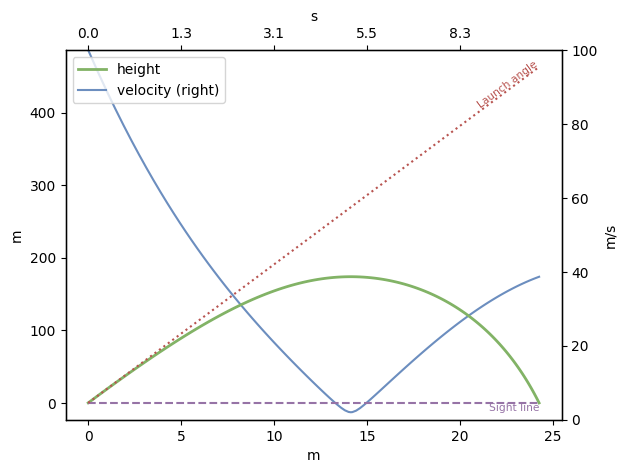

In [6]:
zero = Shot(ammo=Ammo(drag_model, Velocity.MPS(100)), relative_angle=Angular.Degree(87.0))
hit_result = calc.fire(zero, Distance.Meter(1000), time_step=0.1, flags=TrajFlag.APEX, raise_range_error=False)
hit_result.plot()
plt.show()

## Apex data
Looking for the maximum observed height, we find the apex reached 5 seconds after launch at a horizontal distance of 14.1m.

In [7]:
traj_df = hit_result.dataframe()
apex_row = traj_df[traj_df.flag == TrajFlag.APEX].index[0]

df = hit_result.dataframe(True).drop(['slant_height', 'drop_adj', 'windage', 'windage_adj', 'slant_distance', 'density_ratio', 'energy', 'ogw'], axis=1)
df.loc[apex_row-1:apex_row+1]

,time,distance,velocity,mach,height,angle,drag,flag
50,5.000 s,14.0 m,2 m/s,0.01 mach,173.9 m,15.6293 °,1.821e-03,RANGE
51,5.058 s,14.1 m,2 m/s,0.01 mach,173.9 m,-0.0000 °,1.822e-03,APEX
52,5.100 s,14.2 m,2 m/s,0.01 mach,173.9 m,-11.6079 °,1.822e-03,RANGE


# Ex.4: Strong-wind Reversing Trajectory
Here we loft the blunt projectile at 100m/s at a 70° elevation into a 20m/s headwind.  This windspeed blows the projectile backwards so that it impacts the ground behind the firing point.

D:\Code\py-ballisticcalc\py_ballisticcalc\visualize\plot.py:232: UserWarning: Trajectory bends backward; suppressing time axis.
  warnings.warn("Trajectory bends backward; suppressing time axis.")


,distance,velocity,mach,height,slant_height,angle
time,,,,,,
10.500 s,-5.9 m,38 m/s,0.11 mach,18.1 m,18.1 m,-109.3714 °
10.600 s,-7.2 m,39 m/s,0.11 mach,14.4 m,14.4 m,-109.4703 °
10.700 s,-8.5 m,39 m/s,0.11 mach,10.8 m,10.8 m,-109.5689 °
10.800 s,-9.8 m,39 m/s,0.11 mach,7.1 m,7.1 m,-109.6672 °
10.900 s,-11.1 m,39 m/s,0.12 mach,3.5 m,3.5 m,-109.7651 °


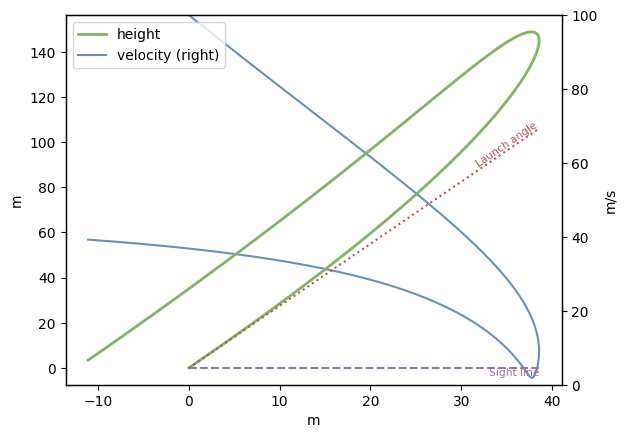

In [8]:
zero = Shot(ammo=Ammo(drag_model, Velocity.MPS(100)), relative_angle=Angular.Degree(70.0))
zero.winds = [Wind(Velocity.MPS(20), Angular.OClock(6))]

hit_result = calc.fire(zero, Distance.Meter(1000), time_step=0.1, raise_range_error=False)
hit_result.plot()

df = hit_result.dataframe(True).drop(['drop_adj', 'windage', 'windage_adj', 'slant_distance', 'density_ratio', 'drag', 'energy', 'ogw', 'flag'], axis=1).set_index('time')
#df.to_clipboard()
df.tail()

# Ex.5: Vacuum Trajectory

In [9]:
# In vacuum we have analytic solutions to trajectory:
# Time to return to ground level t = 2 * v_0 * sin(theta) / gravity
# Horizontal distance x = t * v_0 * cos(theta)
import math
PreferredUnits.distance = Unit.Foot
PreferredUnits.velocity = Unit.FPS
PreferredUnits.drop = Unit.Foot

launch_angle = Angular.Degree(30)
v_0 = -10 * calc.gravity_vector.y
weapon = Weapon(zero_elevation=launch_angle)
shot_info = Shot(weapon=weapon, ammo=Ammo(DragModel(1, TableG1), Velocity.FPS(v_0)), atmo=Vacuum())
t = -2 * v_0 * math.sin(launch_angle >> Angular.Radian) / calc.gravity_vector.y
x = v_0 * t * math.cos(launch_angle >> Angular.Radian)
calc = Calculator(config=BaseEngineConfigDict(cMinimumVelocity=0))
data = calc.fire(shot_info, Distance.Foot(x), Distance.Foot(x/10.0), flags=TrajFlag.ALL)
print(f"In a vacuum, projectile returns to ground after {t:.3f}s at a distance of {x} ft")
data.dataframe(True).drop(['slant_height', 'slant_distance', 'energy', 'ogw', 'windage', 'windage_adj', 'drop_adj', 'density_ratio', 'drag'], axis=1).set_index('time')

In a vacuum, projectile returns to ground after 10.000s at a distance of 2786.3544642630713 ft


,distance,velocity,mach,height,angle,flag
time,,,,,,
0.000 s,0.00 ft,321.7 ft/s,0.29 mach,-0.00 ft,30.0000 °,RANGE
1.000 s,278.64 ft,306.9 ft/s,0.28 mach,144.78 ft,24.7913 °,RANGE
2.000 s,557.27 ft,294.9 ft/s,0.26 mach,257.39 ft,19.1066 °,RANGE
3.000 s,835.91 ft,286.0 ft/s,0.26 mach,337.83 ft,13.0039 °,RANGE
4.000 s,1114.54 ft,280.5 ft/s,0.25 mach,386.09 ft,6.5868 °,RANGE
5.000 s,1393.18 ft,278.6 ft/s,0.25 mach,402.18 ft,0.0000 °,RANGE
5.000 s,1393.18 ft,278.6 ft/s,0.25 mach,402.18 ft,0.0000 °,APEX
6.000 s,1671.81 ft,280.5 ft/s,0.25 mach,386.09 ft,-6.5868 °,RANGE
7.000 s,1950.45 ft,286.0 ft/s,0.26 mach,337.83 ft,-13.0039 °,RANGE


# Ex.6 Max Range and Lofted Zero

In [10]:
from py_ballisticcalc import SciPyEngineConfigDict, loadMetricUnits, UnitPropsDict, UnitProps
UnitPropsDict[Unit.Meter] = UnitProps("meter", 2, "m")
loadMetricUnits()
drag_model = DragModel(bc=0.759, drag_table=TableG1)
ammo = Ammo(drag_model, Velocity.MPS(930))
shot = Shot(ammo=ammo)
config = SciPyEngineConfigDict(cMinimumVelocity=0)
calc = Calculator(config=config, engine="scipy_engine")
max_range, max_angle = calc.find_max_range(shot)
print(f"Max range is {max_range<<Distance.Meter} with elevation={max_angle<<Angular.Degree}")

Max range is 7136.26m with elevation=38.8236°


In [11]:
distance = Distance.Meter(5000)
low_angle = calc.find_zero_angle(shot, distance)
high_angle = calc.find_zero_angle(shot, distance, lofted=True)
print(f"Low angle for {distance << Distance.Meter} is elevation={low_angle << Angular.Degree}")
print(f"High angle for {distance << Distance.Meter} is elevation={high_angle << Angular.Degree}")

Low angle for 5000.0m is elevation=11.7053°
High angle for 5000.0m is elevation=66.4193°


## Plot flat trajectory

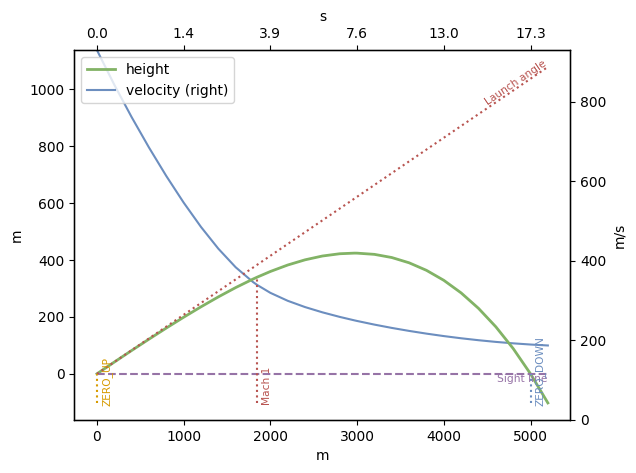

In [12]:
PreferredUnits.drop = Unit.Meter
shot.relative_angle = low_angle
low = calc.fire(shot, trajectory_range=Distance.Meter(5200), trajectory_step=Distance.Meter(200), flags=TrajFlag.ALL)
low.plot()
plt.show()

## Plot lofted trajectory

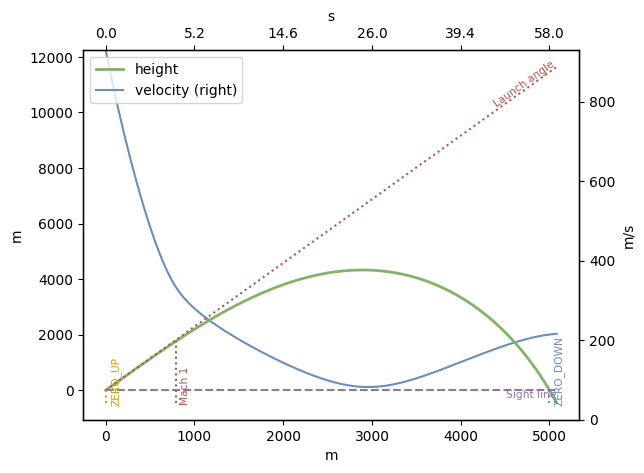

In [13]:
shot.relative_angle = high_angle
high = calc.fire(shot, trajectory_range=Distance.Meter(5200), trajectory_step=Distance.Meter(200),
                 time_step=0.1, flags=TrajFlag.ALL, raise_range_error=False)
high.plot()
plt.show()

## Plot together

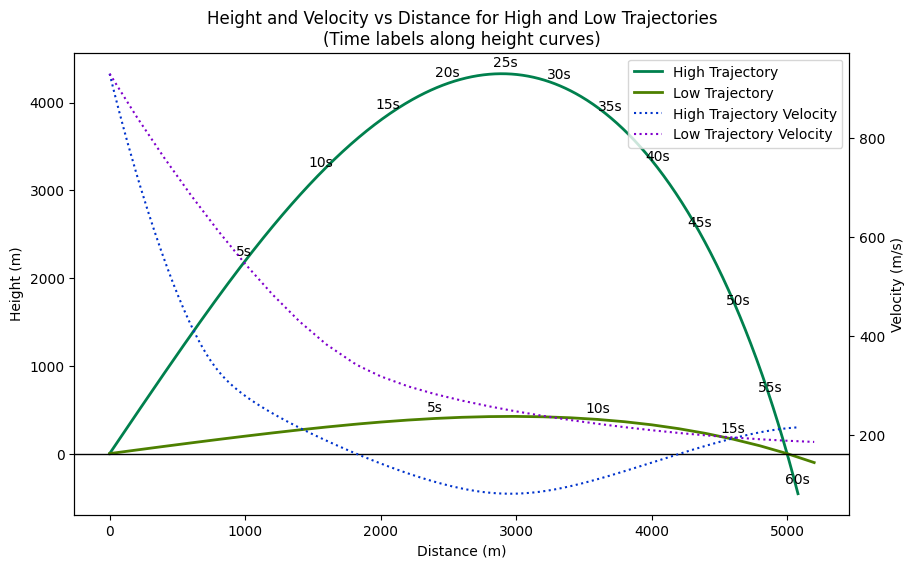

In [14]:
import matplotlib.pyplot as plt
df_high = high.dataframe()[['distance', 'height', 'velocity', 'time']]
df_low = low.dataframe()[['distance', 'height', 'velocity', 'time']]
fig, ax1 = plt.subplots(figsize=(10, 6))
N = 5  # label every N seconds
for df, color, label in [
    (df_high, (0., 0.5, 0.3, 1.0), 'High Trajectory'),
    (df_low, (0.3, 0.5, 0., 1.0), 'Low Trajectory')
]:
    ax1.plot(df['distance'], df['height'], label=label, color=color, linewidth=2)
    last_label_time = -N
    for i in range(len(df)):
        t = df['time'].iloc[i]
        # Only label if time is >= 1 and is a new N-second mark
        if t >= 1 and (int(t) % N == 0) and (int(t) != last_label_time):
            ax1.annotate(f"{t:.0f}s", (df['distance'].iloc[i], df['height'].iloc[i]),
                textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')
            last_label_time = int(t)
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Height (m)')
ax1.axhline(0, color='black', linewidth=1, linestyle='-')  # Horizontal line
ax2 = ax1.twinx()
ax2.plot(df_high['distance'], df_high['velocity'], label='High Trajectory Velocity', color=(0.0, 0.2, 0.8, 1.0), linestyle=':')
ax2.plot(df_low['distance'], df_low['velocity'], label='Low Trajectory Velocity', color=(0.5, 0., 0.8, 1.0), linestyle=':')
ax2.set_ylabel('Velocity (m/s)')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.title('Height and Velocity vs Distance for High and Low Trajectories\n(Time labels along height curves)')
plt.show()